# Intro
- Unsupervised Learning Final Project
- GitHub Repo: https://github.com/mikerhoads/unsupervised-learning-project

# The Problem
From this data set, we are going to explore price predictions for AirBnb listings in New York City. This analysis aims to provide insights into three potential applications:
1. Provide potential real estate investors with insights into the types of homes that influence per-night pricing, allowing them to compare against properties they are considering purchasing.
2. Provide existing AirBnb hosts feedback on the wording of names/descriptions that can affect the pricing of their listings.
3. Provide existing AirBnb hosts guidance on the types of amenities or other features that could be added to the home that affect the price of listings.

In [1]:
import string,re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import Ridge, LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)



# The Data
- Source: 3rd Party website that regularly scrapes AirBnB for listings, metadata, and reviews - https://insideairbnb.com/get-the-data/

In [2]:
#Load the listings and Preview
listings = pd.read_csv("files/input/listings.csv")
listings.head()




,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36121,https://www.airbnb.com/rooms/36121,20250301213336,2025-03-03,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,https://a0.muscache.com/pictures/8776354/35b32...,62165,https://www.airbnb.com/users/show/62165,Michael,2009-12-11,"New York, NY",I’m an urban planner working for an internatio...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/62165/profile...,https://a0.muscache.com/im/users/62165/profile...,Prospect Heights,1.0,3.0,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Prospect Heights,Brooklyn,40.673760,-73.966110,Private room in rental unit,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Refrigerator"", ""Dishes and silverware"", ""Wif...",$200.00,90,365,90.0,90.0,365.0,365.0,90.0,365.0,NaN,t,27,57,87,362,2025-03-03,9,0,0,301,0,0,0.0,2010-12-11,2013-05-10,4.88,5.00,4.80,5.00,5.00,5.00,5.00,NaN,f,1,0,1,0,0.05
1,36647,https://www.airbnb.com/rooms/36647,20250301213336,2025-03-03,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",https://a0.muscache.com/pictures/miso/Hosting-...,157798,https://www.airbnb.com/users/show/157798,Irene,2010-07-04,"New York, NY",NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/e8797...,https://a0.muscache.com/im/pictures/user/e8797...,East Harlem,1.0,1.0,"['email', 'phone']",t,t,Neighborhood highlights,East Harlem,Manhattan,40.792454,-73.940742,Private room in condo,Private room,2,1.0,1 private bath,1.0,1.0,"[""Oven"", ""Blender"", ""Luggage dropoff allowed"",...",$82.00,30,999,30.0,30.0,999.0,999.0,30.0,999.0,NaN,t,0,0,0,204,2025-03-03,102,0,0,143,0,0,0.0,2010-10-04,2023-12-09,4.77,4.82,4.76,4.88,4.90,4.38,4.71,NaN,f,1,0,1,0,0.58
2,38663,https://www.airbnb.com/rooms/38663,20250301213336,2025-03-02,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",https://a0.muscache.com/pictures/miso/Hosting-...,165789,https://www.airbnb.com/users/show/165789,Sarah,2010-07-13,"New York, NY",I am a lawyer and work as an executive at an a...,within a few hours,100%,40%,f,https://a0.muscache.com/im/users/165789/profil...,https://a0.muscache.com/im/users/165789/profil...,Boerum Hill,1.0,3.0,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Boerum Hill,Brooklyn,40.684420,-73.980680,Private room in home,Private room,2,2.5,2.5 baths,5.0,5.0,"[""Portable fans"", ""Oven"", ""Baking sheet"

In [3]:
#Load the reviews and Preview

reviews = pd.read_csv("files/input/reviews.csv")
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


Need to remove non-English reviews, markup and listings that don't have reviews.

In [4]:


# Read and basic cleanup
reviews = pd.read_csv("files/input/reviews.csv")
reviews = reviews[~reviews["comments"].isna()]

# Filter out listings with <= 5 reviews
reviews["review_counts"] = reviews["listing_id"].map(
    reviews["listing_id"].value_counts()
)
reviews = reviews[reviews["review_counts"] > 5]

# Clean comments column
def clean_text(text):
    text = re.sub(r"<.*?>", "", text)              # Remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)        # Keep only letters and spaces
    text = re.sub(r"\s+", " ", text)               # Collapse multiple spaces
    return text.strip().lower()

reviews["comments"] = reviews["comments"].apply(clean_text)

# Filter out very short comments
reviews["word_count"] = reviews["comments"].apply(lambda x: len(x.split()))
reviews = reviews[reviews["word_count"] > 5]


"""
#This will be commented out because it takes 30 mins to run. I"ve saved a version of it at reviews_cleaned so we can pick up from after the language filter runs

#remove non-English reviews
def check_language(s):
    try:
        return detect(s)
    except:
        return "error"
reviews["language"] = reviews["comments"].apply(lambda x: check_language(x))
reviews = reviews[reviews["language"] == "en"]
reviews = reviews[["listing_id", "id", "date", "reviewer_id", "comments", "word_count"]]
reviews.to_csv("files/input/reviews_cleaned.csv", index=False, quoting=1)
"""



'\n#This will be commented out because it takes 30 mins to run. I"ve saved a version of it at reviews_cleaned so we can pick up from after the language filter runs\n\n#remove non-English reviews\ndef check_language(s):\n    try:\n        return detect(s)\n    except:\n        return "error"\nreviews["language"] = reviews["comments"].apply(lambda x: check_language(x))\nreviews = reviews[reviews["language"] == "en"]\nreviews = reviews[["listing_id", "id", "date", "reviewer_id", "comments", "word_count"]]\nreviews.to_csv("files/input/reviews_cleaned.csv", index=False, quoting=1)\n'

In [5]:
rc = pd.read_csv("files/input/reviews_cleaned.csv")

#REMOVE STOP WORDS
rc["comments"] = rc["comments"].apply(
    lambda x: " ".join([word.lower() for word in x.split() if word.lower() not in STOPWORDS])
)

#Recalculate word count after cleanups
rc["word_count"] = rc["comments"].apply(lambda x: len(x.split()))
rc = rc[rc["word_count"] > 5]

#Refilter after removals
# Filter out listings with <= 5 reviews
rc["review_counts"] = rc["listing_id"].map(
    rc["listing_id"].value_counts()
)
rc = rc[rc["review_counts"] > 5]

listings.isna().sum()





id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
name                                                2
description                                       993
neighborhood_overview                           17210
picture_url                                         1
host_id                                             0
host_url                                            0
host_name                                          38
host_since                                         38
host_location                                    7687
host_about                                      15979
host_response_time                              16148
host_response_rate                              16148
host_acceptance_rate                            14694
host_is_superhost           

In [6]:


#Remove listings without a price
listings = listings[~listings["price"].isna()]

#combine all reviews into a single column per each listing id so we can merge and recalc a new review_count since we removed some
grouped_reviews = (
    rc.groupby("listing_id")["comments"]
    .agg([
        ("reviews_text", lambda x: " ".join(x.dropna())),
        ("review_count", "count")
    ])
    .reset_index()
)

#merge with the listings for the final complete listings dataframe
lf = listings.merge(grouped_reviews, left_on="id", right_on="listing_id", how="inner")

keep_columns = ["id", "name", "description", "host_since",  "host_is_superhost", "host_listings_count", "host_identity_verified", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "latitude", "longitude", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights", "minimum_minimum_nights", "availability_30", "availability_60", "availability_90", "availability_365", "number_of_reviews_ltm", "number_of_reviews_l30d", "availability_eoy", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "instant_bookable", "first_review", "review_count", "reviews_text"]
lf = lf[keep_columns]

#Convert price to float
lf["price"] = lf.price.apply(lambda x: float(x.replace("$", "").replace(",","")))

#Fill blanks
lf["description"] = lf["description"].fillna("")
lf["host_listings_count"] = lf["host_listings_count"].fillna(0)
lf["bathrooms"] = lf["bathrooms"].fillna(0)
lf["bedrooms"] = lf["bedrooms"].fillna(0)
lf["beds"] = lf["beds"].fillna(0)
lf["host_is_superhost"] = lf["host_is_superhost"].fillna("f")
lf["host_identity_verified"] = lf["host_identity_verified"].fillna("f")

#convert dates and fill blanks
lf["host_since"] = pd.to_datetime(lf["host_since"])
lf["host_since"] = lf["host_since"].fillna(lf["host_since"].median())

lf["first_review"] = pd.to_datetime(lf["first_review"])

#convert boolean string columns to 1 or 0
lf["host_is_superhost"] = lf["host_is_superhost"].apply(lambda x: 1 if x=="t" else 0)
lf["host_identity_verified"] = lf["host_identity_verified"].apply(lambda x: 1 if x=="t" else 0)
lf["instant_bookable"] = lf["instant_bookable"].apply(lambda x: 1 if x=="t" else 0)

#define text columns
lf["combined_text_fields"] = lf.apply(lambda row: " ".join([row["name"], row["description"], row["amenities"], row["reviews_text"]]), axis=1)
text_predictors = ["name", "description", "amenities", "reviews_text",  "combined_text_fields"]



#lf.head(2).to_csv("files/input/listings_preview.csv", index=False, quoting=1)


# Histogram
Let's get a sense of the distribution

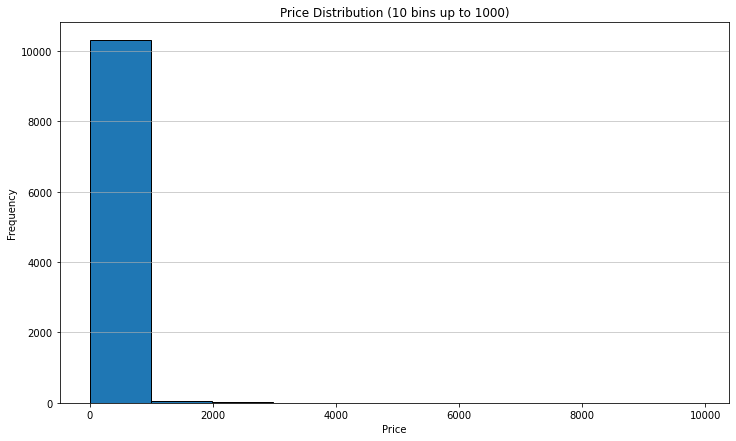

In [7]:
plt.figure(figsize=(12, 7))
plt.hist(lf["price"], bins=10, edgecolor="black")
plt.title("Price Distribution (10 bins up to 1000)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

# Histogram Continued
Yuck...that was not very helpful. Let's set a cap of 1000 for nightly price and see if we can get a more useful histogram.

In [8]:
print(lf["price"].describe())

print("Listings above $1,000: ", len(lf[lf["price"]> 1000]))


count    10382.000000
mean       178.483914
std        217.254640
min          7.000000
25%         90.000000
50%        135.000000
75%        201.000000
max       9894.000000
Name: price, dtype: float64
Listings above $1,000:  72


# Histogram (fixed)
Let's bucket the prices in a way so that everything 1,000 or above gets placed in the last bin. This should make our histogram more digestible.




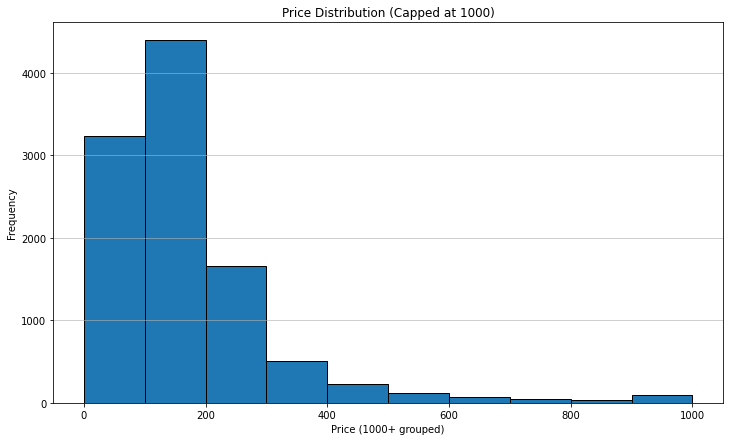

In [9]:
prices = lf["price"]
capped_prices = np.where(prices > 1000, 1000, prices)

# Now use normal bins between 0 and 1000
bins = np.linspace(0, 1000, 11)  # 10 equal bins

plt.figure(figsize=(12, 7))
plt.hist(capped_prices, bins=bins, edgecolor="black")
plt.title("Price Distribution (Capped at 1000)")
plt.xlabel("Price (1000+ grouped)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

# Correlations

Now that the histogram looks better, let's consider the scope and purpose of this study. We can remove the ultra high end / luxury rentals above $1,000 per night and check for correlations with the numerical fields.

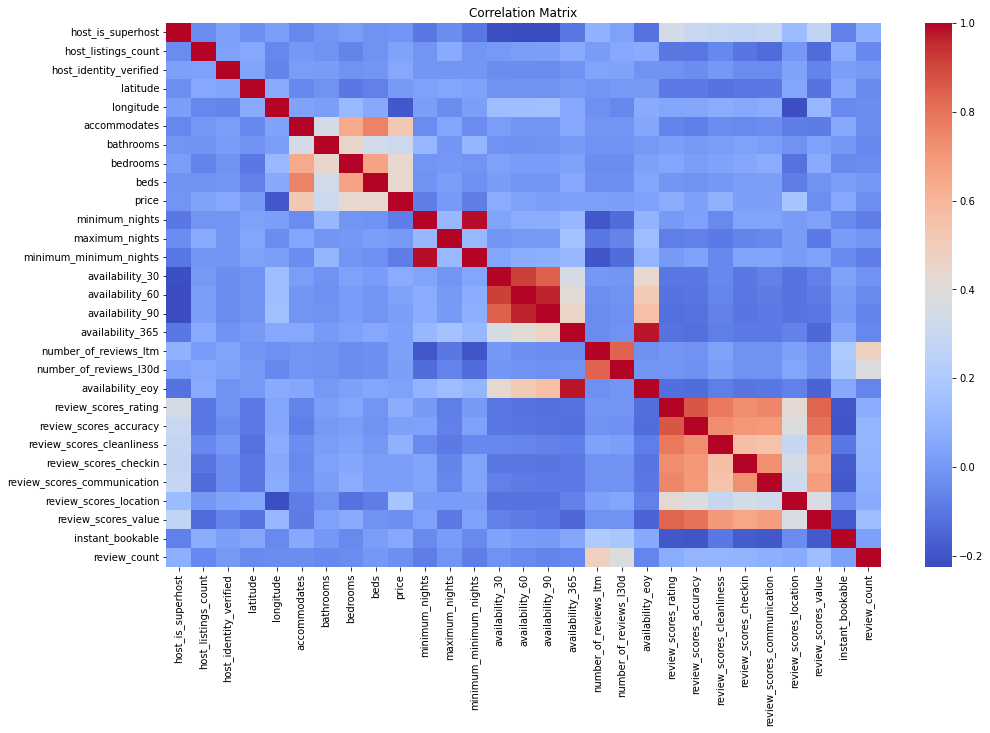

In [10]:

lf = lf[lf["price"] <= 1000]

numeric_predictors = lf.select_dtypes(include=['number']).columns.tolist()
numeric_predictors.remove('id')

corr_matrix = lf[numeric_predictors].corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

numeric_predictors.remove('price')


# Correlation Analysis
There's not much correlation in this chart at all. A few hotspots include:
- Correlation between subcategory of reviews. This makes sense, good reviews tend to have good subcategory ratings becaue the overall is an aggregation of the components.
- There's correlation in "size metrics" bathrooms, capacity, beds. This makes sense because larger properties tend to have more rooms and fit more people.
- As far as price goes, there's only mild correlation between the size metrics and price.


# Word clouds
Let's take a look at our text fields and see if any obvious trends in keywords appear.

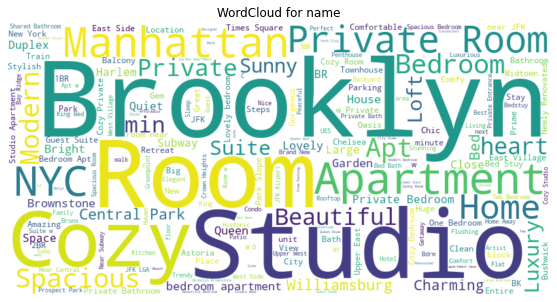

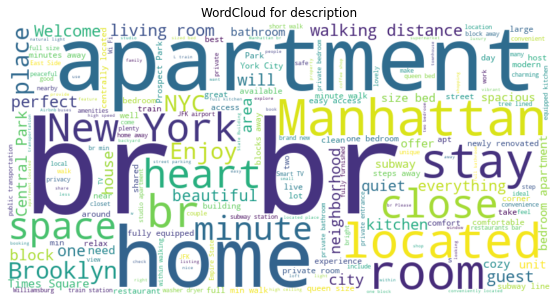

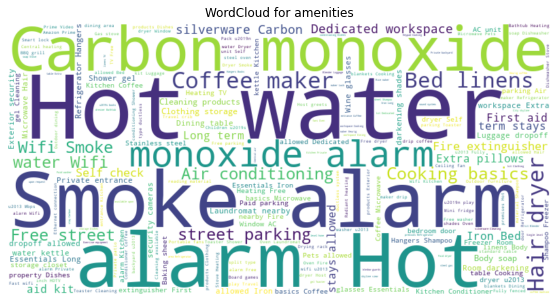

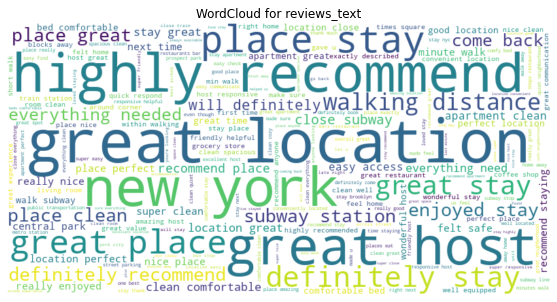

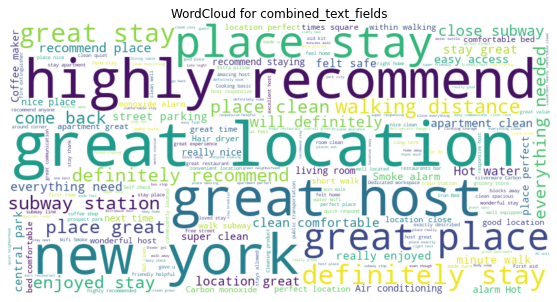

In [11]:
for col in text_predictors:
    text = " ".join(lf[col])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {col}")
    plt.show()

# Word Cloud Results
Some fairly intuitive words pop up frequently. 


# Supervised Learning to Start
Perform a straight  ridge regression on the numeric columns

In [12]:

# Split features & target
X = lf[numeric_predictors]    
y = lf['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Fit a plain linear model
model = Ridge()
model.fit(X_train_scaled, y_train)

# Predict & evaluate
y_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
y_pred = model.predict(X_test_scaled)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)



print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²:   {r2:.3f}")
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_mean))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"The model improves RMSE by {baseline_rmse - rmse:.2f} dollars")

Test RMSE: 94.93
Test R²:   0.459
Baseline RMSE: 129.21
The model improves RMSE by 34.28 dollars


# Unsupervised pt 1: PCA

In [13]:
# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#  PCA to explain 95% of variance
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of PCA components retained: {pca.n_components_}")
print(f"PCA-transformed training set shape: {X_train_pca.shape}")

# 4) Train Ridge regressor model
model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train_pca, y_train)

# 5) Scale & project the test set
X_test_scaled = scaler.transform(X_test)
X_test_pca    = pca.transform(X_test_scaled)
print("Test PCA shape:", X_test_pca.shape)

# 6Predict and evaluate
y_pred = model.predict(X_test_pca)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test MSE:  {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")

print("----Comparing to ---")
y_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_mean))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"The model improves RMSE by {baseline_rmse - rmse:.2f} dollars")
nrmse = rmse / y_test.mean()
print(f"Normalized RMSE: {nrmse:.2%} of average price")
print("Test R²:", r2_score(y_test, y_pred).round(3))


Original number of features: 28
Number of PCA components retained: 24
PCA-transformed training set shape: (8248, 24)
Test PCA shape: (2062, 24)
Test MSE:  9053.860
Test RMSE: 95.152
----Comparing to ---
Baseline RMSE: 129.21
The model improves RMSE by 34.06 dollars
Normalized RMSE: 55.41% of average price
Test R²: 0.457


# Unsupervised Learning Part 2: Non-negative matrix factorization on the text columns

In [14]:


#Split features & target (once)
X = lf[numeric_predictors + text_predictors]
y = lf['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Compute baseline metrics
baseline_pred   = np.full(y_test.shape, y_train.mean())
baseline_rmse   = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2     = r2_score(y_test, baseline_pred)
print(f"Baseline → RMSE: {baseline_rmse:.2f}, R²: {baseline_r2:.3f}")

#Loop over each text column with TF-IDF + NMF
for col in text_predictors:
    print(f"\n--- NMF on “{col}” (TF-IDF) ---")

    # prepare text
    train_txt = X_train[col].fillna('')
    test_txt  = X_test[col].fillna('')

    # TF-IDF vectorization
    vect = TfidfVectorizer(
        max_features=3000,
        stop_words='english'
    )
    X_tr_tfidf = vect.fit_transform(train_txt)
    X_te_tfidf = vect.transform(test_txt)

    # NMF on TF-IDF counts
    nmf = NMF(
        n_components=20,
        solver='mu',
        beta_loss='kullback-leibler',
        max_iter=500,
        random_state=42
    )
    X_tr_nmf = nmf.fit_transform(X_tr_tfidf)
    X_te_nmf = nmf.transform(X_te_tfidf)

    # regress & evaluate
    model = Ridge()
    model.fit(X_tr_nmf, y_train)
    y_pred = model.predict(X_te_nmf)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    print(f"{col} → RMSE: {rmse:.2f}, R²: {r2:.3f}")
    print(f"The model improves RMSE by {baseline_rmse - rmse:.2f} dollars")


Baseline → RMSE: 129.21, R²: -0.002

--- NMF on “name” (TF-IDF) ---
name → RMSE: 124.74, R²: 0.066
The model improves RMSE by 4.47 dollars

--- NMF on “description” (TF-IDF) ---
description → RMSE: 122.46, R²: 0.100
The model improves RMSE by 6.75 dollars

--- NMF on “amenities” (TF-IDF) ---
amenities → RMSE: 120.50, R²: 0.129
The model improves RMSE by 8.71 dollars

--- NMF on “reviews_text” (TF-IDF) ---
reviews_text → RMSE: 100.03, R²: 0.399
The model improves RMSE by 29.18 dollars

--- NMF on “combined_text_fields” (TF-IDF) ---
combined_text_fields → RMSE: 97.51, R²: 0.429
The model improves RMSE by 31.70 dollars


# Results

| Method    | RSME |    R2 |
| -------- | ------- | ------- |
| Baseline (Training Mean)  | 129.21    | -0.002 |
| Supervised on Numerics  | 94.93    | 0.459 |
| PCA on Numerics  |  95.152   | 0.457 |
| NMF w/ Name | 124.74     | 0.066  |
| NMF w/ Desc    | 122.46    | 0.100 |
| NMF w/ Amenities    | 120.50    | 0.129 |
| NMF w/ Reviews    | 100.03    | 0.399 |
| NMF w/ Reviews + Name + Desc + Amenities    | 97.51    | 0.429 |

# Conclusions
1. Numeric features are the strongest standalone signal
- Supervised Ridge on raw numerics: RMSE 94.93, R² 0.459
- PCA on those same numerics (95 % variance): RMSE 95.15, R² 0.457 -> PCA gives you a big dimensionality cut (28 -> ~19 comps) at almost no cost in accuracy.
2. Most text columns add very little on their own
- NMF on name, description or amenities alone barely beats the mean baseline (R² ≲ 0.13).
- Reviews are the outlier: NMF on reviews_text gives RMSE 100.03, R² 0.399.
3. Combining all text fields helps, but still trails numerics
- NMF on reviews + name + desc + amenities → RMSE 97.51, R² 0.429
- That’s better than reviews alone, but not as good as the numeric-only Ridge.

# Potential Follow Ups
- Re-run numeric components without the low-review count listings removed.
- More detail to the geospatial components because raw lat/lon is probably not meaningful in any way. There are better ways to analyze geo data.
- More detail around neighborhood demographics used as numeric predictors.
- Tweak hyperparameters on the NMF powered models.




# References
- Data: https://insideairbnb.com/get-the-data/
- Sklearn: https://scikit-learn.org/0.21/documentation.html
- Langdetect: https://pypi.org/project/langdetect/
- Seaborn: https://seaborn.pydata.org/
- Ridge Regression (via IBM): https://www.ibm.com/think/topics/ridge-regression